In [1]:
import io
import os
from datetime import datetime

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tf.get_logger().setLevel("ERROR")

from tensorflow import keras
from keras import layers

import numpy as np
import pandas as pd

Training dataset: 5994
Test dataset: 5794


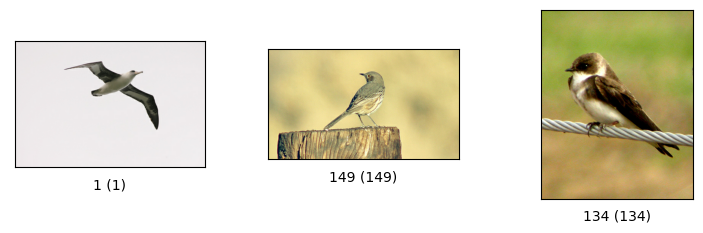

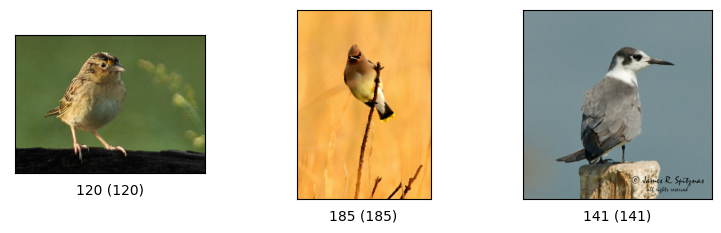

In [2]:
# Settings
batch_size = 16
img_width = 320
img_height = 320

# Fetch dataset
(train_ds_original, test_ds_original), ds_info = tfds.load(
    "caltech_birds2011", 
    split=["train", "test"], 
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

# Display dataset
print("Training dataset: {0}".format(len(train_ds_original)))
print("Test dataset: {0}".format(len(test_ds_original)))

fig = tfds.show_examples(train_ds_original.take(3), ds_info, image_key="image")
fig = tfds.show_examples(test_ds_original.take(3), ds_info, image_key="image")

In [3]:
# Data augmentation
augmentation = keras.Sequential([
    layers.RandomContrast(factor=0.1),
    layers.RandomFlip(mode="horizontal"),
    layers.RandomRotation(factor=0.1),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    
    layers.Rescaling(scale=1./255),
])

num_classes = 5
filter_labels = lambda image, label: label == 0 or label == 1 or label == 2 or label == 5 or label == 4

# indices = list(range(0, num_classes))
# new_labels = tf.one_hot(indices, num_classes)

def modify_images(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    
    image = tf.image.resize_with_pad(
        image,
        img_height, img_width,
        method="bilinear",
        antialias=False,
    )
    
    image = augmentation(image)
    
#     return image, new_labels[label]
    return image, label

# Prepear dataset
train_ds = (
    train_ds_original
    .filter(filter_labels)
    .map(modify_images, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_ds = (
    test_ds_original
    .filter(filter_labels)
    .map(modify_images, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [4]:
# Setup model
model = keras.Sequential([
    # Input
    layers.InputLayer(input_shape=(img_height, img_width, 3)),

    # Block 1
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D(),

    # Block 2
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D(),

    # Block 3
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D(),
    
    # Block 4
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),
    layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(),
    layers.Flatten(),

#     layers.Dense(256, activation="relu"),
#     layers.Dense(num_classes, activation="softmax"),

    layers.Dense(256, activation=None),
    layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)),
])

# Summarize model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 320, 320, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 320, 320, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 160, 160, 64)     0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 160, 160, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 128)     73856     
                                                      

In [5]:
# Prepear model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
#     loss=tf.keras.losses.CategoricalCrossentropy(),
#     loss=tfa.losses.TripletHardLoss(margin=1.4),
    loss=tfa.losses.TripletSemiHardLoss(margin=1.4),
#     metrics=["accuracy"],
)

# Train model
history = model.fit(
    train_ds,
#     validation_data=test_ds,
    epochs=128,
)

# Save model
# model.save("output/model")

Epoch 1/128
10/10 [==============================] - 11s 315ms/step - loss: 1.2896
Epoch 2/128
10/10 [==============================] - 1s 113ms/step - loss: 1.2590
Epoch 3/128
10/10 [==============================] - 1s 113ms/step - loss: 1.2293
Epoch 4/128
10/10 [==============================] - 1s 114ms/step - loss: 1.1780
Epoch 5/128
10/10 [==============================] - 1s 113ms/step - loss: 1.1581
Epoch 6/128
10/10 [==============================] - 1s 113ms/step - loss: 1.1807
Epoch 7/128
10/10 [==============================] - 1s 114ms/step - loss: 1.0969
Epoch 8/128
10/10 [==============================] - 1s 114ms/step - loss: 1.0826
Epoch 9/128
10/10 [==============================] - 1s 114ms/step - loss: 1.0202
Epoch 10/128
10/10 [==============================] - 1s 114ms/step - loss: 0.9362
Epoch 11/128
10/10 [==============================] - 1s 114ms/step - loss: 0.8879
Epoch 12/128
10/10 [==============================] - 1s 115ms/step - loss: 0.7555
Epoch 13/128

Epoch 98/128
10/10 [==============================] - 1s 123ms/step - loss: 0.0000e+00
Epoch 99/128
10/10 [==============================] - 1s 123ms/step - loss: 0.0000e+00
Epoch 100/128
10/10 [==============================] - 1s 123ms/step - loss: 0.0000e+00
Epoch 101/128
10/10 [==============================] - 1s 122ms/step - loss: 0.0000e+00
Epoch 102/128
10/10 [==============================] - 1s 122ms/step - loss: 0.0000e+00
Epoch 103/128
10/10 [==============================] - 1s 122ms/step - loss: 0.0000e+00
Epoch 104/128
10/10 [==============================] - 1s 123ms/step - loss: 0.0000e+00
Epoch 105/128
10/10 [==============================] - 1s 122ms/step - loss: 0.0000e+00
Epoch 106/128
10/10 [==============================] - 1s 123ms/step - loss: 0.0000e+00
Epoch 107/128
10/10 [==============================] - 1s 122ms/step - loss: 0.0000e+00
Epoch 108/128
10/10 [==============================] - 1s 122ms/step - loss: 0.0000e+00
Epoch 109/128
10/10 [=============

<AxesSubplot: >

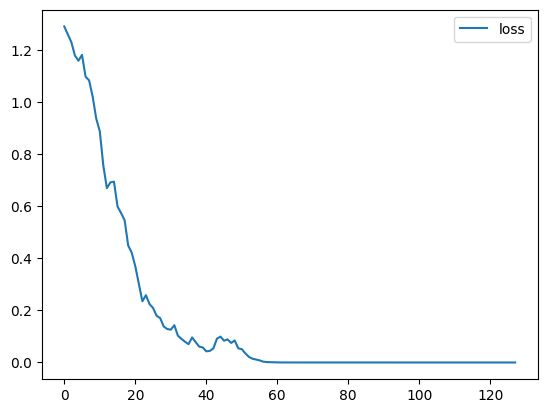

In [6]:
# Plot learning curves
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ["loss"]].plot()
# history_frame.loc[:, ["loss", "val_loss"]].plot()
# history_frame.loc[:, ["accuracy", "val_accuracy"]].plot()

In [7]:
# Test network
test_dataset = train_ds

results = model.predict(test_dataset)

time_sufix = datetime.now().strftime("%H:%M:%S")
np.savetxt("output/vecs-" + time_sufix + ".tsv", results, delimiter="\t")

out_m = io.open("output/meta-" + time_sufix + ".tsv", "w", encoding="utf-8")
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()

10/10 [==============================] - 0s 33ms/step
